In [1]:
import os, glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt 
import scipy
from load import load_data
import time
from generate_features import *
import random

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]  # Bigger images

Let us load ECG data.

In this example we used dataset provided for **PhysioNet/Computing in Cardiology Challenge 2020**. This dataset is unused data (CPSC-Extra Database) from the China Physiological Signal Challenge in 2018 (CPSC2018), held during the 7th International Conference on Biomedical Engineering and Biotechnology in Nanjing, China. The unused data from the CPSC2018 is NOT the test data from the CPSC2018. This training set consists of set of *3,453* (male: 1,843; female: 1,610) of 12-ECG recordings lasting from 6 seconds to 60 seconds. Each recording was sampled at *500 Hz*.  

In [2]:
path = 'data\China 12-Lead ECG Challenge Database'
ecg_data, headers, lables = load_data(path)

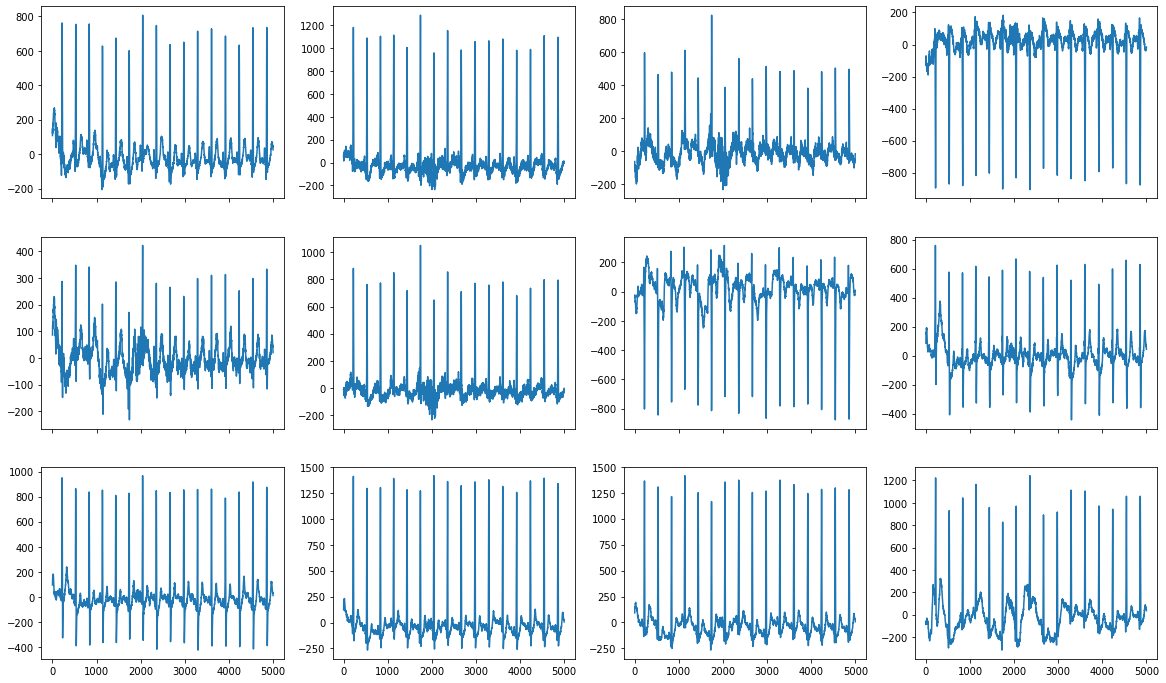

In [3]:
#visulise 10 seconds of all leads of one random signal

num_data = len(ecg_data)
random_number = random.randint(0, num_data)
ecg = ecg_data[random_number]
fig, ax = plt.subplots(3, 4, figsize=(20, 12), sharex=True)
counter = 0
for i in range(3):
    for j in range(4):
        ax[i, j].plot(ecg[counter][:5000]) 
        counter += 1
        
plt.show()

--------------------------------------------------------


In [4]:
features = []
for i in tqdm(range(len(headers))):
    ecg, header = ecg_data[i], headers[i]
    ecg_features = generate_features(ecg, header)
    age, sex = get_general_features(header)
    features.append([ecg_features, age, sex])

100%|██████████████████████████████████████████████████████████████████████████████| 3453/3453 [31:15<00:00,  1.84it/s]


In [66]:
df = pd.DataFrame(features, columns=['ecg_features', 'age', 'sex'])
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

column_names = []
for iline in header:
    if '.mat' in iline:
        name = iline.split(' 0 ')[2].strip()
        column_names.append(name)

df[column_names] = df.ecg_features.apply(pd.Series).iloc[:, :12]
df.drop('ecg_features', axis=1, inplace=True)

for name in column_names:
    expand_df = df[name].apply(pd.Series)
    expand_df = expand_df.drop(0, axis=1)
    df[name + "_" + expand_df.columns] = expand_df
    df.drop(name, axis=1, inplace=True)
    for subname in expand_df.columns:
        expand_subdf = df[name + "_" + subname].apply(pd.Series)
        expand_subdf = expand_subdf.drop(0, axis=1)
        df[name + "_" + subname + "_" + expand_subdf.columns] = expand_subdf
        df.drop(name + "_" + subname, axis=1, inplace=True)

In [71]:
df.head()

,age,sex,I_Area/Dur_P_max,I_Area/Dur_P_meadian,I_Area/Dur_P_mean,I_Area/Dur_P_min,I_Area/Dur_P_std,I_Area_under_P_max,I_Area_under_P_meadian,I_Area_under_P_mean,...,V6_P_dur_max,V6_P_dur_meadian,V6_P_dur_mean,V6_P_dur_min,V6_P_dur_std,V6_Time_till_P_max,V6_Time_till_P_meadian,V6_Time_till_P_mean,V6_Time_till_P_min,V6_Time_till_P_std
0,53.0,0,46.142334,17.651530,17.546707,-9.492117,10.793719,3783.671369,1692.740684,1687.646884,...,182.0,122.0,131.000000,0.0,22.891046,106.0,69.0,69.875000,0.0,14.238482
1,55.0,0,0.973428,-5.344906,-5.242127,-8.456705,2.036278,89.555337,-483.069076,-464.950859,...,166.0,142.0,142.285714,0.0,12.892016,92.0,74.0,70.857143,0.0,15.037368
2,57.0,0,9.148565,4.966900,5.605272,0.000000,2.231373,878.262240,506.623840,534.403046,...,130.0,126.0,122.615385,0.0,7.457969,84.0,72.0,71.384615,0.0,8.607139
3,51.0,1,31.264624,10.017153,9.183755,-12.507435,6.691094,2276.487954,1133.613632,1021.982062,...,150.0,128.0,127.392857,0.0,10.426064,92.0,72.0,72.321429,0.0,11.456606
4,20.0,1,29.396088,10.623160,11.220626,-8.472647,8.021139,2560.100157,1042.611152,1093.383991,...,114.0,108.0,107.481481,0.0,4.732632,70.0,60.0,59.185185,0.0,5.340530


In [73]:
df.to_csv('./data/ecg_features.csv', index=False)

In order to save dataframe to SQL database import *sqlite_db* module. Also this module allows to open SQL db file as pd.DataFrame. Example of usage is below:

In [77]:
from sqlite_db import * 

save_to_sqldb(path= './data/', name = 'ecg_features', df = df)

Database sucessfully saved!


In [75]:
df_test = read_sqlite_db(path= './data/', name = 'ecg_features')

In [82]:
df_test.head()

,age,sex,I_Area/Dur_P_max,I_Area/Dur_P_meadian,I_Area/Dur_P_mean,I_Area/Dur_P_min,I_Area/Dur_P_std,I_Area_under_P_max,I_Area_under_P_meadian,I_Area_under_P_mean,...,V6_P_dur_max,V6_P_dur_meadian,V6_P_dur_mean,V6_P_dur_min,V6_P_dur_std,V6_Time_till_P_max,V6_Time_till_P_meadian,V6_Time_till_P_mean,V6_Time_till_P_min,V6_Time_till_P_std
0,53.0,0,46.142334,17.651530,17.546707,-9.492117,10.793719,3783.671369,1692.740684,1687.646884,...,182.0,122.0,131.000000,0.0,22.891046,106.0,69.0,69.875000,0.0,14.238482
1,55.0,0,0.973428,-5.344906,-5.242127,-8.456705,2.036278,89.555337,-483.069076,-464.950859,...,166.0,142.0,142.285714,0.0,12.892016,92.0,74.0,70.857143,0.0,15.037368
2,57.0,0,9.148565,4.966900,5.605272,0.000000,2.231373,878.262240,506.623840,534.403046,...,130.0,126.0,122.615385,0.0,7.457969,84.0,72.0,71.384615,0.0,8.607139
3,51.0,1,31.264624,10.017153,9.183755,-12.507435,6.691094,2276.487954,1133.613632,1021.982062,...,150.0,128.0,127.392857,0.0,10.426064,92.0,72.0,72.321429,0.0,11.456606
4,20.0,1,29.396088,10.623160,11.220626,-8.472647,8.021139,2560.100157,1042.611152,1093.383991,...,114.0,108.0,107.481481,0.0,4.732632,70.0,60.0,59.185185,0.0,5.340530
